In [1]:
import torch
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Make sure to include parentheses to instantiate
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Correctly instantiated
])

# Download and load the training data
trainset = datasets.CIFAR100('~/.pytorch/CIFAR100_data/', download=True, train=True, transform=transform)

#primary purpose of a DataLoader is to batch the data, shuffle it, and enable parallel processing using multiple worker threads
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)



Files already downloaded and verified


In [2]:
from torch import nn, optim
#nn.Module, is the base class for all neural network modules in PyTorch
#provides the class with a wealth of functionality, including the ability to keep track of all the trainable parameters 

class CIFAR100Reverser(nn.Module):
    def __init__(self):
        super(CIFAR100Reverser, self).__init__() #super calls from main branch
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # In channel, out channel, and kernel size
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # first is windo size(2^2) and second the stride(how many pixels after each kernel operation the window will move)
        self.fc = nn.Sequential( #sequence of fully connected layers
            nn.Linear(128 * 4 * 4, 1024),# designed to take the flattened output from the preceding convolutional and pooling layers. The input size 128 * 4 * 4
           #(window sizes is 2^2, and 128 is the max output channel size)
            nn.ReLU(),#it introduces non-linearity into the model, allowing the network to learn complex patterns in the data
            nn.Linear(1024, 32 * 32 * 3),  # Output size = 32*32*3 for CIFAR-100 images when unrolled into a single vector
            nn.Tanh()# activation function scales the output of the network to be between -1 and 1
        )

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) # "-1" is used for the batch dimension, allowing this operation to work regardless of the batch size
        return self.fc(x)

model = CIFAR100Reverser()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)



In [3]:
epochs = 10  # Consider more epochs due to the increased dataset complexity
for e in range(epochs):
    running_loss = 0
    for images, _ in trainloader:
        # Add noise to images
        noisy_images = images + torch.randn(*images.shape) * 0.3 #The noise has the same pixel shape of the images
        noisy_images = torch.clamp(noisy_images, 0, 1)
 
        #If the gradients were not cleared, the gradient values would accumulate from multiple forward and backward passes, 
        #leading to incorrect updates to the model parameters.       
        optimizer.zero_grad()
        
        output = model(noisy_images)

# images.shape[0]: This retrieves the size of the first dimension of the images tensor, which typically represents the batch size in a batch
# This reshapes the images tensor into a 2D tensor where the first dimension is the batch size        
        loss = criterion(output, images.view(images.shape[0], -1))
#calculus to propagate the loss backward through the network layers, from the output layer through to the input layer. This allows the 
#computation of the gradient of the loss with respect to the inputs of each layer 
        loss.backward()

#optimizer.step() is the step that directly adjusts the model's parameters, using the gradients 
    #computed during backpropagation to steer the model towards lower loss values.        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")



Training loss: 0.07551481621935392
Training loss: 0.0473368494959591
Training loss: 0.042193390919691154
Training loss: 0.0390608081370211
Training loss: 0.03687381599088917
Training loss: 0.03522471072690566
Training loss: 0.03390409671189382
Training loss: 0.03278620519658641
Training loss: 0.03201285568173127
Training loss: 0.03131460874815426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


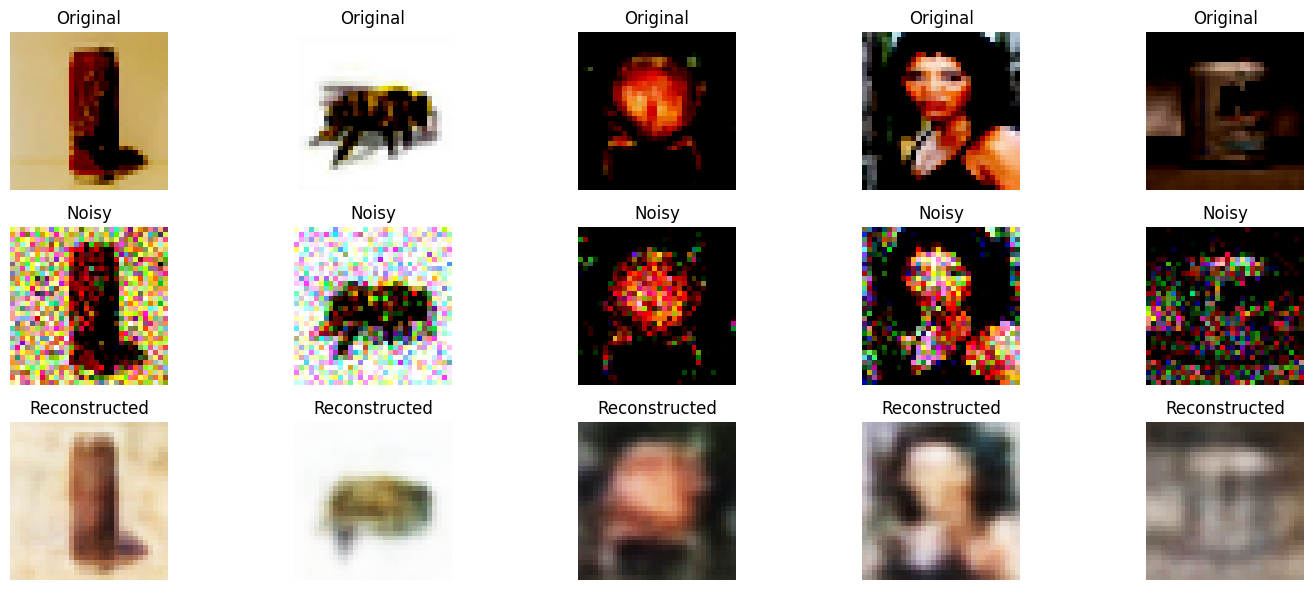

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = (img + 1) / 2  # Adjusted unnormalization for Tanh output
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) #in matplotlib it is (H,W,Ch)
    plt.axis('off')

# Get a batch of images from the dataset
dataiter = iter(trainloader) # Creating an iterator a form od data loader
images, labels = next(dataiter) # Fetching a batch

# Select the first 5 images and add noise
selected_images = images[:5]
noisy_images = selected_images + torch.randn(*selected_images.shape) * 0.3
noisy_images = torch.clamp(noisy_images, 0, 1)

# Pass the noisy images through the model
#Disabling gradient calculation reduces memory usage and speeds up computations--you're only doing forward passes
with torch.no_grad():
    model.eval() #informs all layers within your model that they are in evaluation mode
    
    # Ensure the input to the model is correctly shaped
    generated_images = model(noisy_images)
    # No need to view/reshape if the model output is already in the correct shape

# Display the original, noisy, and reconstructed images
fig, axes = plt.subplots(3, 5, figsize=(15, 6))  # Ensure this is defined correctly

for i in range(5):
    # Original images
    ax = axes[0, i]
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title('Original')
    ax.axis('off')
    
    # Noisy images
    ax = axes[1, i]
    ax.imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))
    ax.set_title('Noisy')
    ax.axis('off')

    # Reconstructed (denoised) images
# When shifting from pytorch to matplotlib you need to transpose    
    reconstructed_img = generated_images[i].view(3, 32, 32)  # Reshape the flat vector to image dimensions
    reconstructed_img = (reconstructed_img + 1) / 2  # Unnormalize if the last layer of the model is Tanh
    reconstructed_img = np.transpose(reconstructed_img.cpu().numpy(), (1, 2, 0))  # Convert to numpy and adjust dimensions for plotting
    ax = axes[2, i]
    ax.imshow(reconstructed_img)
    ax.set_title('Reconstructed')
    ax.axis('off')

plt.tight_layout()
plt.show()
